# Local Outlier Factor (LOF) 

`LOF(Local Outlier Factor)` 알고리즘은 이웃과 관련하여 주어진 데이터 포인트의 로컬 밀도 편차를 계산하는 비지도 학습 이상 탐지 방법입니다. 

- 각 데이터 포인트의 로컬 밀도를 인접 데이터 포인트와 비교하고 밀도가 낮은 데이터 포인트를 비정상 또는 특이값으로 식별합니다.

다음을 학습 합니다.

- 특이치 검출(novelty detection)과 outlier detection의 차이점  
- 특이치 검출(novelty detection)을 위해 LOF(Local Outlier Factor)를 사용하는 방법
- 비정상(anomaly) 또는 이상치(outlier) 탐지를 위해 LOF(Local Outlier Factor)를 사용하는 방법

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 불균형 데이터세트 만들기 
- 서로 다른 mechanism 으로 생성된 두가지 data 를 하나로 섞어서 생성

In [2]:
np.random.seed(42)

# 정상 데이터(inlier) 생성
# 평균 0, 표준편차 0.3인 정규분포를 따르는 2000개의 2차원 데이터 생성
X_inliers = 0.3 * np.random.randn(2000, 2)
print(X_inliers.shape)  # 생성된 inlier 데이터의 형태 출력

# 이상치 데이터(outlier) 생성
# 범위 -4에서 0 사이의 균등분포를 따르는 200개의 2차원 데이터 생성
X_outliers = np.random.uniform(low=-4, high=0, size=(200, 2))

# inlier와 outlier 데이터를 하나의 배열로 결합
X = np.vstack([X_inliers, X_outliers])
print(X.shape)  # 결합된 전체 데이터의 형태 출력

# 이상치(outlier)의 개수
n_outliers = len(X_outliers)

# 정상 데이터는 0, 이상치는 1로 레이블을 부여
y = np.zeros(len(X), dtype=int)  # 전체 데이터 길이만큼 0으로 초기화된 배열 생성
y[-n_outliers:] = 1  # 마지막 n_outliers 개수만큼 1로 설정

print(y.shape)  # 레이블 배열의 형태 출력

# 전체 데이터에서 이상치가 차지하는 비율을 출력
print("이상치 비율 = {}".format(len(X_outliers) / len(X)))

(2000, 2)
(2200, 2)
(2200,)
이상치 비율 = 0.09090909090909091


- data 시각화

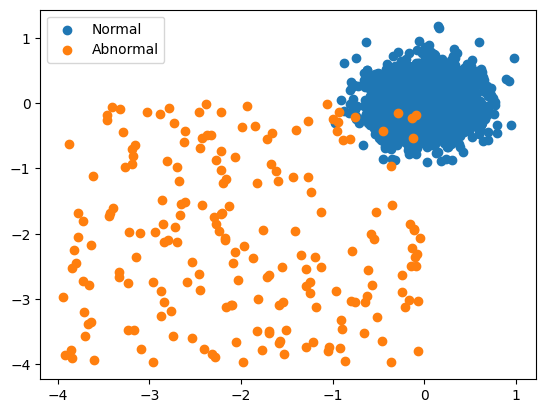

In [3]:
# Inliers (정상 데이터) 플롯
# X_inliers의 첫 번째 열과 두 번째 열 데이터를 사용하여 산점도를 그립니다.
plt.scatter(X_inliers[:, 0], X_inliers[:, 1], label='Normal')

# Outliers (이상치 데이터) 플롯
# X_outliers의 첫 번째 열과 두 번째 열 데이터를 사용하여 산점도를 그립니다.
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], label='Abnormal')

# 범례를 추가하여 각 데이터의 레이블을 표시합니다.
plt.legend()
plt.show()

In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('훈련 데이터세트의 레코드 수 : ', X_train.shape[0])
print('테스트 데이터세트의 레코드 수 : ', X_test.shape[0])
print(f"훈련 데이터세트의 minority class 수 : {sorted(Counter(y_train).items())[1][1]}")

훈련 데이터세트의 레코드 수 :  1760
테스트 데이터세트의 레코드 수 :  440
훈련 데이터세트의 minority class 수 : 160


## Outlier/anomaly Detection Vs. Novelty Detection

- LOF(Local Outlier Factor) 알고리즘은 이상치 검출(outlier/anomaly detection) 및 특이치 검출(Novelty Detection)에 모두 사용할 수 있습니다. Outlier / Anomaly Detection 및 Novelty Detection의 차이점은 훈련 데이터 세트에 있습니다.  

    - Outlier/anomaly detection에는 훈련 데이터 세트의 이상치가 포함됩니다. 이 알고리즘은 고밀도 데이터가 있는 영역에 적합하고 outlier 및 anomaly를 무시합니다.

    - Novelty Detection에는 모델을 훈련할 때 normal data point 만 포함됩니다. 그런 다음 모델은 예측을 위해 Outlier/Anomaly가 포함되어 있는 새 데이터 세트를 사용합니다. Novelty Detection의 이상값을 novelty (특이치) 라고도 합니다.
    

- outlier label 이 있는 데이터 세트가 있는 경우 두가지 모두에 사용할 수 있습니다. 그렇지 않으면 정상 데이터만으로 이루어진 훈련 데이터 세트를 얻을 수 없기 때문에 outlier detection 만 사용할 수 있습니다.


- 고려되는 neighbor 수 (파라미터 n_neighbors)를 몇개로 하는지 정해진 것은 없으며 n_neighbors = 20을 사용하면 일반적으로 잘 작동하는 것으로 보입니다.

### 1. Local Outlier Factor (LOF) 를 사용한 특이치 검출 (Novelty Detection)

- Novelty Detection을 사용하려면 LOF 의 novelty 파라미터를 True로 설정해야 합니다. 
```
LocalOutlierFactor(n_neighbors=20, novelty=True)
```
- normal data로만 구성된 train set으로 모델을 fitting 하고 outlier를 포함하는 test dataset을 predict 합니다.

In [5]:
# 훈련 데이터 세트에서 normal (정상) 데이터만 유지
# y_train이 0인 인덱스를 찾아 해당 인덱스의 X_train 데이터를 선택합니다.
X_train_normal = X_train[np.where(y_train == 0)]

# 정상 데이터만으로 Local Outlier Factor (LOF) 모델을 생성 및 학습
# n_neighbors=20: 각 포인트의 이웃을 20개로 설정
# novelty=True: 새 데이터의 이상치 여부를 예측하기 위해 사용
lof_novelty = LocalOutlierFactor(n_neighbors=20, novelty=True)

# 정상 데이터만 사용하여 LOF 모델을 학습시킵니다.
lof_novelty.fit(X_train_normal)

LocalOutlierFactor(novelty=True)

In [6]:
# test dataset 에서 novelty 예측
prediction_novelty = lof_novelty.predict(X_test)
prediction_novelty[:10]

array([ 1,  1,  1,  1,  1,  1,  1, -1,  1,  1])

In [7]:
# prediction_novelty 리스트에서 각 요소를 확인하고, -1이면 1로, 그렇지 않으면 0으로 변경합니다.
# -1은 이상치를 나타내고, 0은 정상 데이터를 나타냅니다. 
# 이를 0과 1로 변환하여 이상치 예측 결과를 보다 직관적으로 해석할 수 있도록 합니다.
prediction_novelty = [1 if i == -1 else 0 for i in prediction_novelty]

# prediction_novelty 리스트의 처음 10개 요소를 출력합니다.
print(prediction_novelty[:10])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [8]:
# model 성능 측정
print(classification_report(y_test, prediction_novelty))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       400
           1       0.87      0.97      0.92        40

    accuracy                           0.98       440
   macro avg       0.93      0.98      0.95       440
weighted avg       0.99      0.98      0.98       440



### 2. LOF(Local Outlier Factor)를 사용한 이상치 감지 (outlier detection) 
- 위와 동일한 데이터 세트에서 outlier detection을 훈련하고 예측하기 위한 LOF(Local Outlier Factor).   
- normal 과 outlier 가 섞여 있는 dataset 으로 fit_predict 해야 합니다.
- Outlier Detection algorithm을 활성화하려면 novelty=`False`로 설정해야 합니다. 
```
LocalOutlierFactor(n_neighbors=5, novelty=False)  
```
- X_test 로 측정한 모델간 비교를 위해 X_test 사용

In [9]:
# 이상치 감지를 위한 LOF(Local Outlier Factor) 모델 생성
# n_neighbors=20: 각 포인트의 이웃을 20개로 설정
# novelty=False: 기존 데이터에서 이상치를 감지하기 위해 사용
lof_outlier = LocalOutlierFactor(n_neighbors=20, novelty=False)

# 정상 데이터와 이상치 데이터가 섞인 테스트 데이터를 사용하여 예측
# fit_predict 메서드는 모델을 학습시키고 이상치 여부를 예측합니다.
# -1은 이상치(outlier)를, 1은 정상 데이터(inlier)를 나타냅니다.
prediction_outlier = lof_outlier.fit_predict(X_test)

# 예측 결과의 처음 100개 요소를 출력합니다.
print(prediction_outlier[:100])

[ 1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1]


In [10]:
# -1 을 0으로, 1을 0으로 변경
prediction_outlier = [1 if i==-1 else 0 for i in prediction_outlier]

# model 성능 측정
print(classification_report(y_test, prediction_outlier))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       400
           1       0.50      0.33      0.39        40

    accuracy                           0.91       440
   macro avg       0.72      0.65      0.67       440
weighted avg       0.90      0.91      0.90       440



- 시각화를 통한 특이치 검축 / 이상치 검출 결과 비교

In [11]:
# 시각화를 위해 X_test, y_test를 DataFrame으로 변환
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['prediction_novelty'] = prediction_novelty
df_test['prediction_outlier'] = prediction_outlier
df_test.head()

,feature1,feature2,y_test,prediction_novelty,prediction_outlier
0,-0.170950,0.098853,0,0,0
1,0.165690,0.187689,0,0,0
2,-0.289699,0.488750,0,0,0
3,-0.027420,-0.024264,0,0,0
4,-0.872096,-0.112447,0,0,1


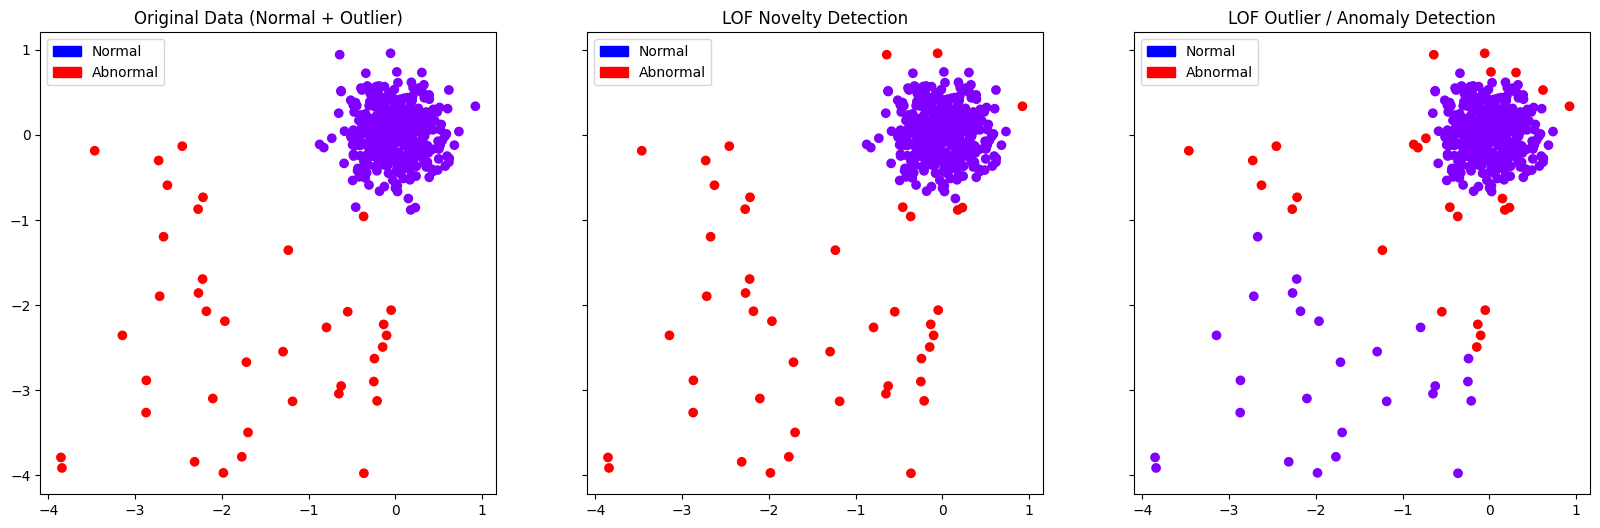

In [12]:
import matplotlib.patches as mpatches

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 6))

# 원본 데이터 (정상 + 이상치)
# 산점도 그리기 (정상 데이터는 0, 이상치는 1)
ax0.set_title('Original Data (Normal + Outlier)')  
ax0.scatter(df_test['feature1'], df_test['feature2'], 
            c=df_test['y_test'], cmap='rainbow')  

# LOF 특이치 검출 결과
# 산점도 그리기 (예측된 특이치)
ax1.set_title('LOF Novelty Detection') 
ax1.scatter(df_test['feature1'], df_test['feature2'], 
            c=df_test['prediction_novelty'], cmap='rainbow')  

# LOF 이상치 검출 결과
# 산점도 그리기 (예측된 이상치)
ax2.set_title('LOF Outlier / Anomaly Detection')  
ax2.scatter(df_test['feature1'], df_test['feature2'], 
            c=df_test['prediction_outlier'], cmap='rainbow')  

# 범례 항목 생성
normal_patch = mpatches.Patch(color='blue', label='Normal')  # 정상 데이터를 나타내는 파란색 범례 항목 생성
abnormal_patch = mpatches.Patch(color='red', label='Abnormal')  # 이상치를 나타내는 빨간색 범례 항목 생성

# 각 축에 범례 추가
ax0.legend(handles=[normal_patch, abnormal_patch])  
ax1.legend(handles=[normal_patch, abnormal_patch])  
ax2.legend(handles=[normal_patch, abnormal_patch])  

plt.show()

- Novelty Detection model 에서는 minoriy observation 들을 특이치로 분류  
- Anomaly Detection model 에서는 저밀도 영역을 정상으로 분류하고 밀도가 다른 영역을 이상치로 분류